In [1]:
import pickle

import numpy as np
import pymc3 as pm
import theano.tensor as tt
import pymbar

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from _BAR_estimator import get_values_from_trace
from _BAR_estimator import bayes_factor_smc
from _BAR_estimator import fit_normal_trace
from _BAR_estimator import draw_normal_samples
from _BAR_estimator import pot_ener_normal_aug
from _BAR_estimator import pot_ener
from _BAR_estimator import bootstrap_BAR
from _BAR_estimator import fit_uniform_trace
from _BAR_estimator import draw_uniform_samples
from _BAR_estimator import pot_ener_uniform_aug

In [2]:
SEED = 2039
SIZE = 50

SMC_STEPS = 10000
MET_STEPS = 100000

# Data Generation

In [3]:
def gaussian_mixture(mu1=0, sigma1=1, mu2=0, sigma2=1,
                     rho=0.5, size=100, random_state=None):
    rnd = np.random.RandomState(random_state)
    x = []
    for _ in range(size):
        if rnd.rand() < rho:
            x.append(rnd.normal(loc=mu1, scale=sigma1))
        else:
            x.append(rnd.normal(loc=mu2, scale=sigma2))
    return np.array(x)

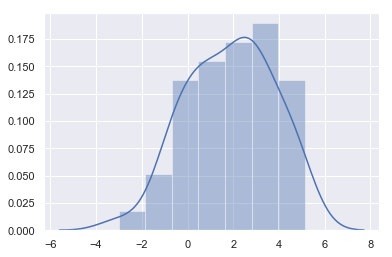

In [4]:
x = gaussian_mixture(mu1=0, sigma1=1, mu2=3, sigma2=1, rho=0.5, size=SIZE, random_state=SEED)
sns.distplot(x)

# Models

## Model 1

In [5]:
def make_model_m1():
    with pm.Model() as model_m1:
        mu = pm.Uniform("mu", lower=-10, upper=10)
        sigma = pm.Uniform("sigma", lower=0.1, upper=5)
        obs = pm.Normal("obs", mu=mu, sigma=1, observed=x)
    return model_m1

## Model 2

In [6]:
def make_model_m2():
    with pm.Model() as model_m2:
        w = pm.floatX([.5, .5])
        sigmas = pm.floatX([1., 1])
        
        mu = pm.Uniform("mu", lower=-10, upper=10)
        dmu = pm.Uniform("dmu", lower=0, upper=10)
        means = tt.zeros([2])
        means = tt.set_subtensor(means[0], mu)
        means = tt.set_subtensor(means[1], mu + dmu)
        
        sigma1 = pm.Uniform("sigma1", lower=0.1, upper=5)
        sigma2 = pm.Uniform("sigma2", lower=0.1, upper=5)
        sigmas = tt.zeros([2])
        sigmas = tt.set_subtensor(sigmas[0], sigma1)
        sigmas = tt.set_subtensor(sigmas[1], sigma2)
        obs = pm.NormalMixture("obs", w=w, mu=means, sigma=sigmas, observed=x)
    return model_m2

# Sequential Monte Carlo

In [ ]:
model_m1 = make_model_m1()
print(model_m1.vars)

with model_m1:
    trace_m1 = pm.sample(SMC_STEPS, step=pm.SMC())
pm.traceplot(trace_m1[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_m1.marginal_likelihood)))

pickle.dump(model_m1, open("data/model_m1_smc.pickle", "wb"))
del model_m1, trace_m1

In [ ]:
model_m2 = make_model_m2()
print(model_m2.vars)

with model_m2:
    trace_m2 = pm.sample(SMC_STEPS, step=pm.SMC())
pm.traceplot(trace_m2[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_m2.marginal_likelihood)))
pickle.dump(model_m2, open("data/model_m2_smc.pickle", "wb"))
del model_m2, trace_m2

In [7]:
bf_smc_2_vs_1 = bayes_factor_smc(pickle.load(open("data/model_m1_smc.pickle", "rb")), 
                                 pickle.load(open("data/model_m2_smc.pickle", "rb")))
print("Log10 of SMC Bayes factor model m2 over model m1: %0.5f" % bf_smc_2_vs_1)

Log10 of SMC Bayes factor model m2 over model m1: 12.07818


# BAR estimator

In [8]:
def bayes_factor_uniform_aug(model_ini, sample_ini, model_fin, sample_fin, bootstrap=None):
    
    lower_upper_fin = fit_uniform_trace(sample_fin)
    lower_upper_fin = {"dmu_interval__": lower_upper_fin["dmu_interval__"],
                       "sigma2_interval__": lower_upper_fin["sigma2_interval__"]}
    
    # potential for sample drawn from i estimated at state i
    nsamples_ini = len(sample_ini["mu_interval__"])
    sample_aug_ini = draw_uniform_samples(lower_upper_fin, nsamples_ini)
    u_i_i = pot_ener_uniform_aug(sample_ini, model_ini, sample_aug_ini, lower_upper_fin)
    
    # potential for sample drawn from i estimated at state f
    sample_ini_comb = {"mu_interval__": sample_ini["mu_interval__"],
                       "sigma1_interval__": sample_ini["sigma_interval__"]}
    sample_ini_comb.update(sample_aug_ini)
    u_i_f = pot_ener(sample_ini_comb, model_fin)
    
    # potential for sample drawn from f estimated at state f
    u_f_f = pot_ener(sample_fin, model_fin)
    
    # potential for sample drawn from f estimated at state i
    sample_fin_split = {"mu_interval__": sample_fin["mu_interval__"], 
                        "sigma_interval__": sample_fin["sigma1_interval__"]}
    sample_aug_fin = {"dmu_interval__": sample_fin["dmu_interval__"], 
                      "sigma2_interval__": sample_fin["sigma2_interval__"]}
    u_f_i = pot_ener_uniform_aug(sample_fin_split, model_ini, sample_aug_fin, lower_upper_fin)
    
    w_F = u_i_f - u_i_i
    w_R = u_f_i - u_f_f

    delta_F = pymbar.BAR(w_F, w_R, compute_uncertainty=False, relative_tolerance=1e-12, verbose=True)
    bf = -delta_F

    if bootstrap is None:
        print("log10(bf) = %0.5f" % (bf *np.log10(np.e)))
        return bf
    else:
        print("Running %d bootstraps to estimate error." % bootstrap)
        bf_err = bootstrap_BAR(w_F, w_R, bootstrap)
        print("log10(bf) = %0.5f +/- %0.5f" % (bf * np.log10(np.e), bf_err * np.log10(np.e)))
        return bf, bf_err

In [9]:
def bayes_factor_normal_aug(model_ini, sample_ini, model_fin, sample_fin, sigma_robust=False, bootstrap=None):
    
    mu_sigma_fin = fit_normal_trace(sample_fin, sigma_robust=sigma_robust)
    mu_sigma_fin = {"dmu_interval__": mu_sigma_fin["dmu_interval__"],
                    "sigma2_interval__": mu_sigma_fin["sigma2_interval__"]}
    
    # potential for sample drawn from i estimated at state i
    nsamples_ini = len(sample_ini["mu_interval__"])
    sample_aug_ini = draw_normal_samples(mu_sigma_fin, nsamples_ini)
    u_i_i = pot_ener_normal_aug(sample_ini, model_ini, sample_aug_ini, mu_sigma_fin)
    
    # potential for sample drawn from i estimated at state f
    sample_ini_comb = {"mu_interval__": sample_ini["mu_interval__"],
                       "sigma1_interval__": sample_ini["sigma_interval__"]}
    sample_ini_comb.update(sample_aug_ini)
    u_i_f = pot_ener(sample_ini_comb, model_fin)
    
    # potential for sample drawn from f estimated at state f
    u_f_f = pot_ener(sample_fin, model_fin)
    
    # potential for sample drawn from f estimated at state i
    sample_fin_split = {"mu_interval__": sample_fin["mu_interval__"], 
                        "sigma_interval__": sample_fin["sigma1_interval__"]}
    sample_aug_fin = {"dmu_interval__": sample_fin["dmu_interval__"], 
                      "sigma2_interval__": sample_fin["sigma2_interval__"]}
    u_f_i = pot_ener_normal_aug(sample_fin_split, model_ini, sample_aug_fin, mu_sigma_fin)
    
    w_F = u_i_f - u_i_i
    w_R = u_f_i - u_f_f

    delta_F = pymbar.BAR(w_F, w_R, compute_uncertainty=False, relative_tolerance=1e-12, verbose=True)
    bf = -delta_F

    if bootstrap is None:
        print("log10(bf) = %0.5f" % (bf *np.log10(np.e)))
        return bf
    else:
        print("Running %d bootstraps to estimate error." % bootstrap)
        bf_err = bootstrap_BAR(w_F, w_R, bootstrap)
        print("log10(bf) = %0.5f +/- %0.5f" % (bf * np.log10(np.e), bf_err * np.log10(np.e)))
        return bf, bf_err

In [10]:
def repeat_sample(sample, repeats):
    sample = sample.copy()
    for k in sample.keys():
        sample[k] = np.repeat(sample[k], repeats)
    return sample

# Metropolis MC

[mu_interval__, sigma_interval__]


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 201000/201000 [00:51<00:00, 3876.03draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2d8906d8>,
      dtype=object)

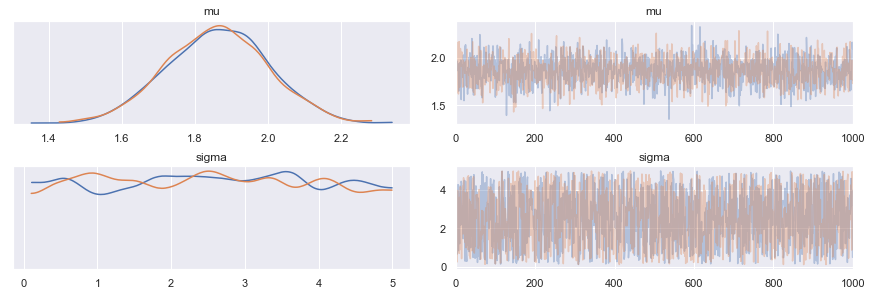

In [11]:
model_m1 = make_model_m1()
print(model_m1.vars)
with model_m1:
    trace_m1 = pm.sample(MET_STEPS, step=pm.Metropolis())
pm.traceplot(trace_m1[::100])

[mu_interval__, dmu_interval__, sigma1_interval__, sigma2_interval__]


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma2]
>Metropolis: [sigma1]
>Metropolis: [dmu]
>Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 201000/201000 [01:44<00:00, 1925.54draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2eca2dd8>,
      dtype=object)

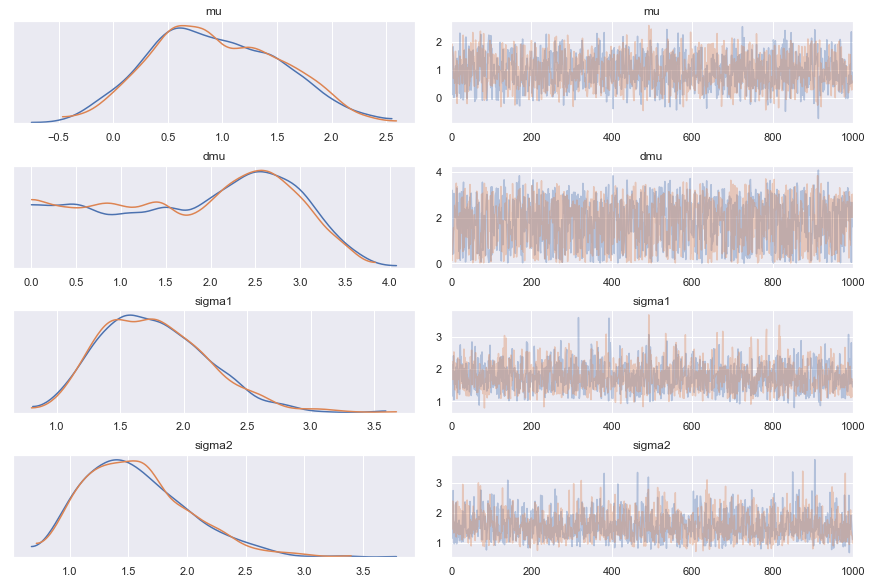

In [12]:
model_m2 = make_model_m2()
print(model_m2.vars)
with model_m2:
    trace_m2 = pm.sample(MET_STEPS, step=pm.Metropolis())
pm.traceplot(trace_m2[::100])

In [13]:
sample_m1 = get_values_from_trace(model_m1, trace_m1, thin=10, burn=100)
sample_m2 = get_values_from_trace(model_m2, trace_m2, thin=10, burn=100)

# Augmenting with uniformly-drawn samples

In [14]:
bayes_factor_uniform_aug(model_m1, sample_m1, model_m2, sample_m2, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =          -27.752
relative_change =        0.000
iteration     1: DeltaF =          -27.751
relative_change =        0.000
iteration     2: DeltaF =          -27.751
relative_change =        0.000
iteration     3: DeltaF =          -27.751
Convergence achieved.
Converged to tolerance of 1.000000e-15 in 4 iterations (7 function evaluations)
DeltaF =  -27.751
Running 100 bootstraps to estimate error.
log10(bf) = 12.05228 +/- 0.01515


(27.75141107014518, 0.034874071803023425)

## Augmenting 10 more times

In [15]:
sample_m1_repeat = repeat_sample(sample_m1, 10)
bayes_factor_uniform_aug(model_m1, sample_m1_repeat, model_m2, sample_m2, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =          -27.726
relative_change =        0.000
iteration     1: DeltaF =          -27.727
relative_change =        0.000
iteration     2: DeltaF =          -27.727
relative_change =        0.000
iteration     3: DeltaF =          -27.727
relative_change =        0.000
Convergence achieved.
Converged to tolerance of 4.048902e-14 in 4 iterations (7 function evaluations)
DeltaF =  -27.727
Running 100 bootstraps to estimate error.
log10(bf) = 12.04188 +/- 0.00878


(27.727453701928336, 0.020212767506884683)

# Augmenting with normally-drawn samples

In [16]:
bayes_factor_normal_aug(model_m1, sample_m1, model_m2, sample_m2, sigma_robust=True, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =          -27.722
relative_change =        0.000
iteration     1: DeltaF =          -27.719
relative_change =        0.000
iteration     2: DeltaF =          -27.719
relative_change =        0.000
iteration     3: DeltaF =          -27.719
relative_change =        0.000
iteration     4: DeltaF =          -27.719
Convergence achieved.
Converged to tolerance of 1.000000e-15 in 5 iterations (8 function evaluations)
DeltaF =  -27.719
Running 100 bootstraps to estimate error.
log10(bf) = 12.03824 +/- 0.01282


(27.719076115905334, 0.029528978906865976)

## Augmenting 10 more times

In [17]:
sample_m1_repeat = repeat_sample(sample_m1, 10)
bayes_factor_normal_aug(model_m1, sample_m1_repeat, model_m2, sample_m2, sigma_robust=True, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =          -27.742
relative_change =        0.000
iteration     1: DeltaF =          -27.743
relative_change =        0.000
iteration     2: DeltaF =          -27.743
relative_change =        0.000
iteration     3: DeltaF =          -27.743
relative_change =        0.000
Convergence achieved.
Converged to tolerance of 1.070573e-13 in 4 iterations (7 function evaluations)
DeltaF =  -27.743
Running 100 bootstraps to estimate error.
log10(bf) = 12.04854 +/- 0.00861


(27.74279274418264, 0.01983218759787229)

# Use wider priors

## Model 3

In [18]:
def make_model_m3():
    with pm.Model() as model_m3:
        mu = pm.Uniform("mu", lower=-50, upper=50)
        sigma = pm.Uniform("sigma", lower=0.1, upper=10)
        obs = pm.Normal("obs", mu=mu, sigma=1, observed=x)
    return model_m3

## Model 4

In [19]:
def make_model_m4():
    with pm.Model() as model_m4:
        w = pm.floatX([.5, .5])
        sigmas = pm.floatX([1., 1])
        mu = pm.Uniform("mu", lower=-50, upper=50)
        dmu = pm.Uniform("dmu", lower=0, upper=50)
        means = tt.zeros([2])
        means = tt.set_subtensor(means[0], mu)
        means = tt.set_subtensor(means[1], mu + dmu)
        
        sigma1 = pm.Uniform("sigma1", lower=0.1, upper=10)
        sigma2 = pm.Uniform("sigma2", lower=0.1, upper=10)
        sigmas = tt.zeros([2])
        sigmas = tt.set_subtensor(sigmas[0], sigma1)
        sigmas = tt.set_subtensor(sigmas[1], sigma2)
        
        obs = pm.NormalMixture("obs", w=w, mu=means, sigma=sigmas, observed=x)
    
    return model_m4

## Sequential Monte Carlo

[mu_interval__, sigma_interval__]


Sample initial stage: ...
Stage: 0 Beta: 0.000 Steps: 25
Stage: 1 Beta: 0.001 Steps: 7
Stage: 2 Beta: 0.005 Steps: 3
Stage: 3 Beta: 0.040 Steps: 5
Stage: 4 Beta: 0.292 Steps: 4
Stage: 5 Beta: 1.000 Steps: 4


Log10 marginal likelihood: -60.53866


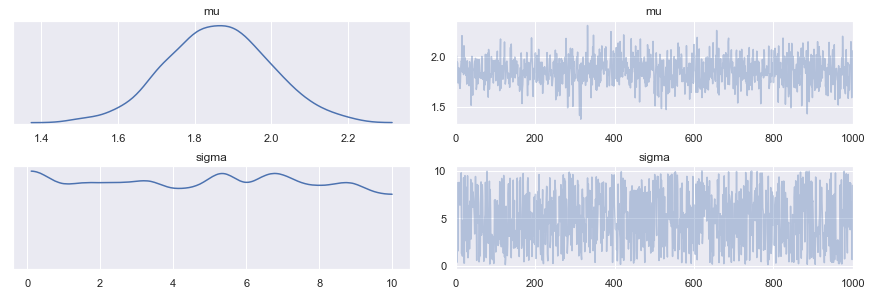

In [20]:
model_m3 = make_model_m3()
print(model_m3.vars)

with model_m3:
    trace_m3 = pm.sample(SMC_STEPS, step=pm.SMC())
pm.traceplot(trace_m3[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_m3.marginal_likelihood)))

pickle.dump(model_m3, open("data/model_m3_smc.pickle", "wb"))
del model_m3, trace_m3

[mu_interval__, dmu_interval__, sigma1_interval__, sigma2_interval__]


Sample initial stage: ...
Stage: 0 Beta: 0.006 Steps: 25
Stage: 1 Beta: 0.030 Steps: 14
Stage: 2 Beta: 0.067 Steps: 4
Stage: 3 Beta: 0.117 Steps: 22
Stage: 4 Beta: 0.189 Steps: 4
Stage: 5 Beta: 0.323 Steps: 19
Stage: 6 Beta: 0.637 Steps: 3
Stage: 7 Beta: 1.000 Steps: 11


Log10 marginal likelihood: -49.79997


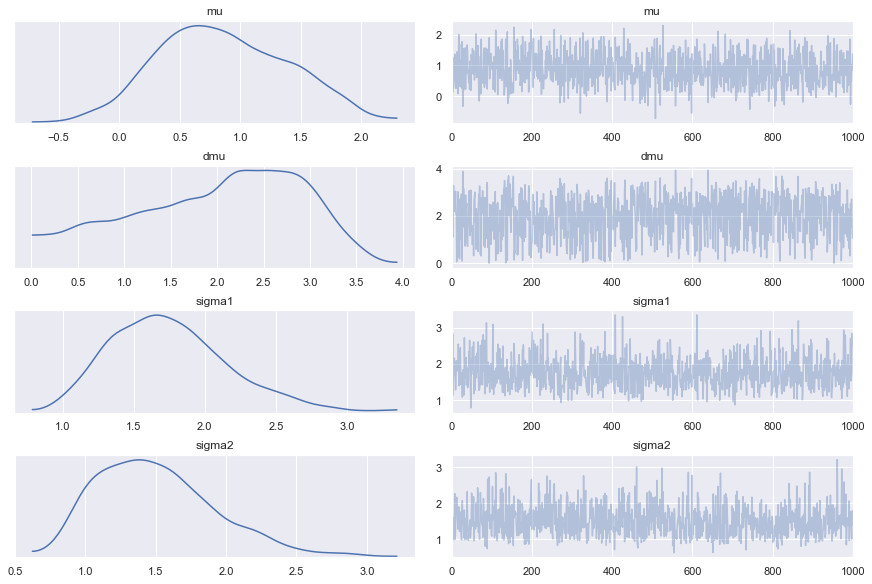

In [21]:
model_m4 = make_model_m4()
print(model_m4.vars)

with model_m4:
    trace_m4 = pm.sample(SMC_STEPS, step=pm.SMC())
pm.traceplot(trace_m4[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_m4.marginal_likelihood)))

pickle.dump(model_m4, open("data/model_m4_smc.pickle", "wb"))
del model_m4, trace_m4

In [23]:
bf_smc_3_vs_1 = bayes_factor_smc(pickle.load(open("data/model_m1_smc.pickle", "rb")), 
                                 pickle.load(open("data/model_m3_smc.pickle", "rb")))
print("Log10 of SMC Bayes factor model m3 over model m1: %0.5f" % bf_smc_3_vs_1)

Log10 of SMC Bayes factor model m3 over model m1: -0.71814


In [24]:
bf_smc_4_vs_2 = bayes_factor_smc(pickle.load(open("data/model_m2_smc.pickle", "rb")), 
                                 pickle.load(open("data/model_m4_smc.pickle", "rb")))
print("Log10 of SMC Bayes factor model m4 over model m2: %0.5f" % bf_smc_4_vs_2)

Log10 of SMC Bayes factor model m4 over model m2: -2.05764


In [22]:
bf_smc_4_vs_3 = bayes_factor_smc(pickle.load(open("data/model_m3_smc.pickle", "rb")), 
                                 pickle.load(open("data/model_m4_smc.pickle", "rb")))
print("Log10 of SMC Bayes factor model m4 over model m3: %0.5f" % bf_smc_4_vs_3)

Log10 of SMC Bayes factor model m4 over model m3: 10.73868
